In [1]:
import os
from typing import List, Tuple

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms.functional as TF

读取数据集

In [2]:
image_dir = [
    "../data/DRIVE/training/images/21_training.tif",
    "../data/DRIVE/training/images/22_training.tif",
]
mask_dir = [
    "../data/DRIVE/training/1st_manual/21_manual1.gif",
    "../data/DRIVE/training/1st_manual/22_manual1.gif",
]

匹配image和mask

In [12]:
pairs = []
image_suffixes = ("_training.tif",)
mask_suffixes = ("_manual1.gif",)

for fname in image_dir:
    # fname 就是完整路径，例如 ../data/DRIVE/training/images/21_training.tif
    img_name = os.path.basename(fname)                  # 21_training.tif
    if not img_name.lower().endswith(image_suffixes):
        continue

    img_stem = img_name.split("_")[0]                   # 21




    # 去 mask 目录中查找对应的 mask
    found_mask = None
    for ms in mask_suffixes:
        candidate = img_stem + ms                       # 21_manual1.gif

        for md in mask_dir:
            # md 就是 mask 的完整路径，不是目录，所以需要取目录名
            print(md)
            md_dir = os.path.dirname(md)
            candidate_path = os.path.join(md_dir, candidate)

            if os.path.exists(candidate_path):
                found_mask = candidate_path
                break
        if found_mask is not None:
            break

    if found_mask is None:
        print(f"[WARN] No mask found for image: {fname}")
        continue

    pairs.append((fname, found_mask))

print(pairs)

../data/DRIVE/training/1st_manual/21_manual1.gif
../data/DRIVE/training/1st_manual/21_manual1.gif
[('../data/DRIVE/training/images/21_training.tif', '../data/DRIVE/training/1st_manual/21_manual1.gif'), ('../data/DRIVE/training/images/22_training.tif', '../data/DRIVE/training/1st_manual/22_manual1.gif')]


In [4]:
def extract_patches_128(
    img: torch.Tensor,
    patch_size: int = 128,
    padding_mode: str = "reflect"
) -> Tuple[torch.Tensor, List[Tuple[int, int]], Tuple[int, int], Tuple[int, int]]:
    # 如果是单通道的 (H, W)，加一个 channel 维度 -> (1, H, W)
    if img.dim() == 2:
        img = img.unsqueeze(0)  # (1, H, W)
    elif img.dim() != 3:
        raise ValueError(f"img must be 2D or 3D tensor, got shape {img.shape}")

    C, H, W = img.shape
    orig_size = (H, W)

    # 计算底部和右侧需要 padding 多少，保证 Hp 和 Wp 能被 patch_size 整除
    pad_h = (patch_size - H % patch_size) % patch_size
    pad_w = (patch_size - W % patch_size) % patch_size

    # F.pad 的顺序是 (left, right, top, bottom)
    padding = (0, pad_w, 0, pad_h)

    if pad_h > 0 or pad_w > 0:
        img_padded = F.pad(img, padding, mode=padding_mode)
    else:
        img_padded = img

    _, Hp, Wp = img_padded.shape
    padded_size = (Hp, Wp)

    # 使用 unfold 做滑动窗口（这里 stride = patch_size，不重叠）
    # unfold(维度, kernel_size, stride)
    patches = img_padded.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    # 现在形状是 (C, num_patches_h, num_patches_w, patch_size, patch_size)

    num_patches_h = patches.size(1)
    num_patches_w = patches.size(2)

    # 调整维度顺序并展平为 (N, C, patch_size, patch_size)
    patches = (
        patches.permute(1, 2, 0, 3, 4)  # -> (num_patches_h, num_patches_w, C, patch_size, patch_size)
               .contiguous()
               .view(-1, C, patch_size, patch_size)
    )

    # 记录每个 patch 在“填充后图像”中的左上角坐标 (top, left)
    coords: List[Tuple[int, int]] = []
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            top = i * patch_size
            left = j * patch_size
            coords.append((top, left))

    return patches, coords, orig_size, padded_size


In [5]:
if len(pairs) == 0:
    raise RuntimeError("No Image/mask pairs found.")

patch_size = 128
img_padding_mode = "reflect"
mask_padding_mode = "reflect"
img_patches: List[torch.Tensor] = []
mask_patches: List[torch.Tensor] = []
all_img_patches = []
all_mask_patches = []

for img_path,mask_path in pairs:
    img = Image.open(img_path).convert("RGB")
    img_tensor = TF.to_tensor(img)

    mask = Image.open(mask_path).convert("L")
    mask_np = torch.from_numpy(
        (TF.to_tensor(mask)*255).squeeze(0).byte().numpy()
    ).long()

    if img_tensor.shape[1:] != mask_np.shape:
        raise ValueError(
            f"Image and mask size mismatch: {img_path}, {mask_path}, "
            f"img={img_tensor.shape}, mask={mask_np.shape}"
        )

    img_patches,_,_,_ = extract_patches_128(
        img_tensor,
        patch_size = patch_size,
        padding_mode = img_padding_mode
    )

    mask_patches, _, _, _ = extract_patches_128(
        mask_np,
        patch_size=patch_size,
        padding_mode=mask_padding_mode
    )


    if len(img_patches) != len(mask_patches):
        raise RuntimeError(
            f"Patch number not equal for {img_path} and {mask_path}: "
            f"{img_patches.shape[0]} vs {mask_patches.shape[0]}"
        )

    if mask_patches.dim() == 3:
        mask_patches = mask_patches.unsqueeze(1)

    all_img_patches.extend(img_patches)
    all_mask_patches.extend(mask_patches)

print(f"[INFO] Total patches: {len(all_img_patches)}")

[INFO] Total patches: 50


In [6]:
imgs_tensor = torch.stack(all_img_patches)
masks_tensor = torch.stack(all_mask_patches)

In [7]:
print(f"[INFO] imgs.shape: {imgs_tensor.shape}")
print(f"[INFO] masks.shape: {masks_tensor.shape}")

[INFO] imgs.shape: torch.Size([50, 3, 128, 128])
[INFO] masks.shape: torch.Size([50, 1, 128, 128])


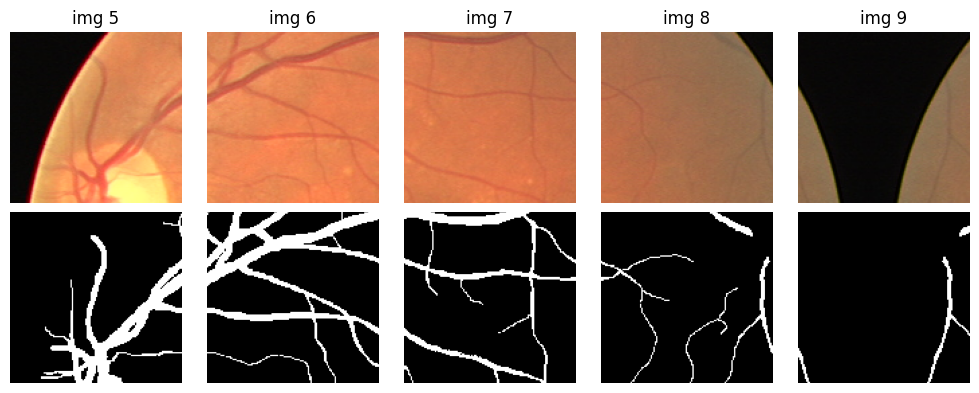

In [8]:
import matplotlib.pyplot as plt

# 先把 Tensor 变成 numpy，方便 imshow
imgs_np = imgs_tensor.permute(0, 2, 3, 1).cpu().numpy()   # [N, 128, 128, 3]
masks_np = masks_tensor.squeeze(1).cpu().numpy()          # [N, 128, 128]

def show_patch_pairs(start_idx: int = 0, num_per_row: int = 5):
    """
    显示从 start_idx 开始的 num_per_row 对 image/mask patch
    上一行是 image，下一行是对应的 mask
    """
    end_idx = min(start_idx + num_per_row, imgs_np.shape[0])
    n = end_idx - start_idx
    if n <= 0:
        print("start_idx 超出范围")
        return

    # figsize 可以调小一点，图就更小
    fig, axes = plt.subplots(2, n, figsize=(2 * n, 4))

    for col, idx in enumerate(range(start_idx, end_idx)):
        # 第一行：原图 patch
        axes[0, col].imshow(imgs_np[idx])
        axes[0, col].axis("off")
        axes[0, col].set_title(f"img {idx}")

        # 第二行：mask patch
        axes[1, col].imshow(masks_np[idx], cmap="gray")
        axes[1, col].axis("off")

    plt.tight_layout()
    plt.show()

# 示例：显示前 5 对 patch
show_patch_pairs(start_idx=5, num_per_row=5)


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 假设 imgs_tensor / masks_tensor 已经是 float / long 等合适的类型
dataset = TensorDataset(imgs_tensor, masks_tensor)

train_loader = DataLoader(
    dataset,
    batch_size=8,      # 自己调
    shuffle=True,
    num_workers=0      # 在 Jupyter 里一般先用 0，避免多进程问题
)
